# Proje: Twitter Sentiment Analysis

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split 
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
data = pd.read_csv('Sentiment.csv')
# Sadece gerekli sütunları alıyoruz
data = data[['text','sentiment']]

In [4]:
# Veri setini eğitim ve test setlerine ayırma
train, test = train_test_split(data,test_size = 0.1)
# Nötr duyguları kaldırma
train = train[train.sentiment != "Neutral"]

Bir sonraki adımda, eğitim setindeki Olumlu ve Olumsuz tweetleri, içerdikleri kelimeleri kolayca görselleştirmek için ayırıyoruz.

Positive words


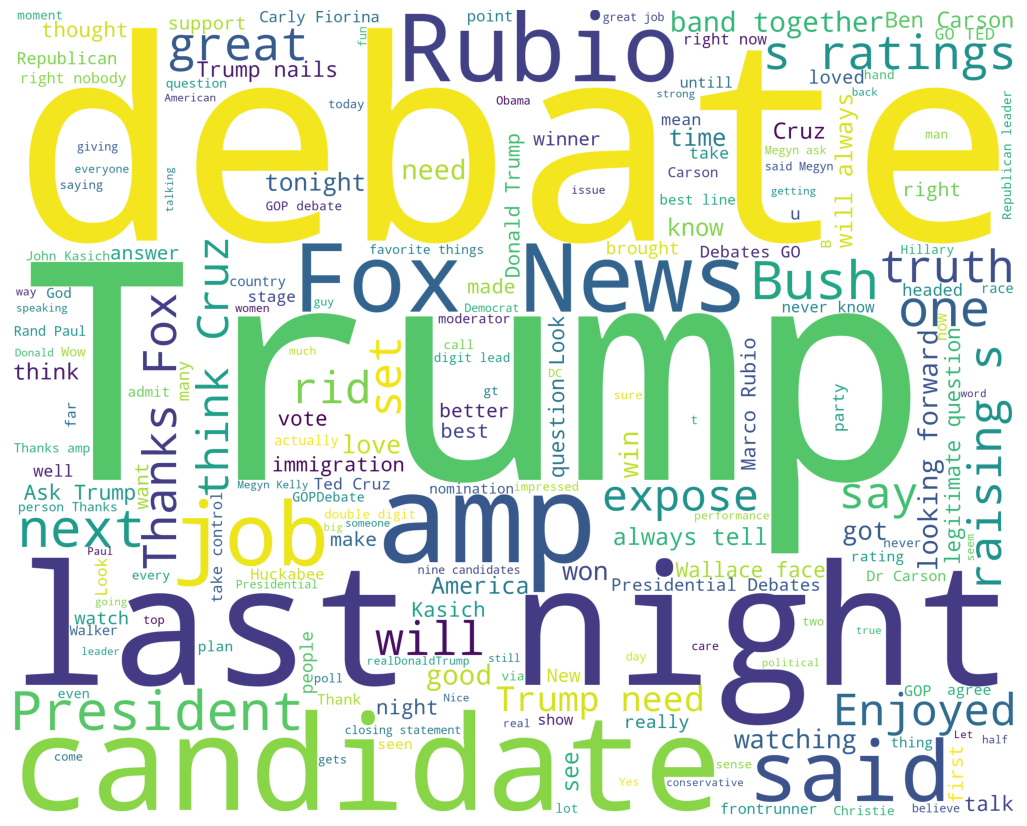

Negative words


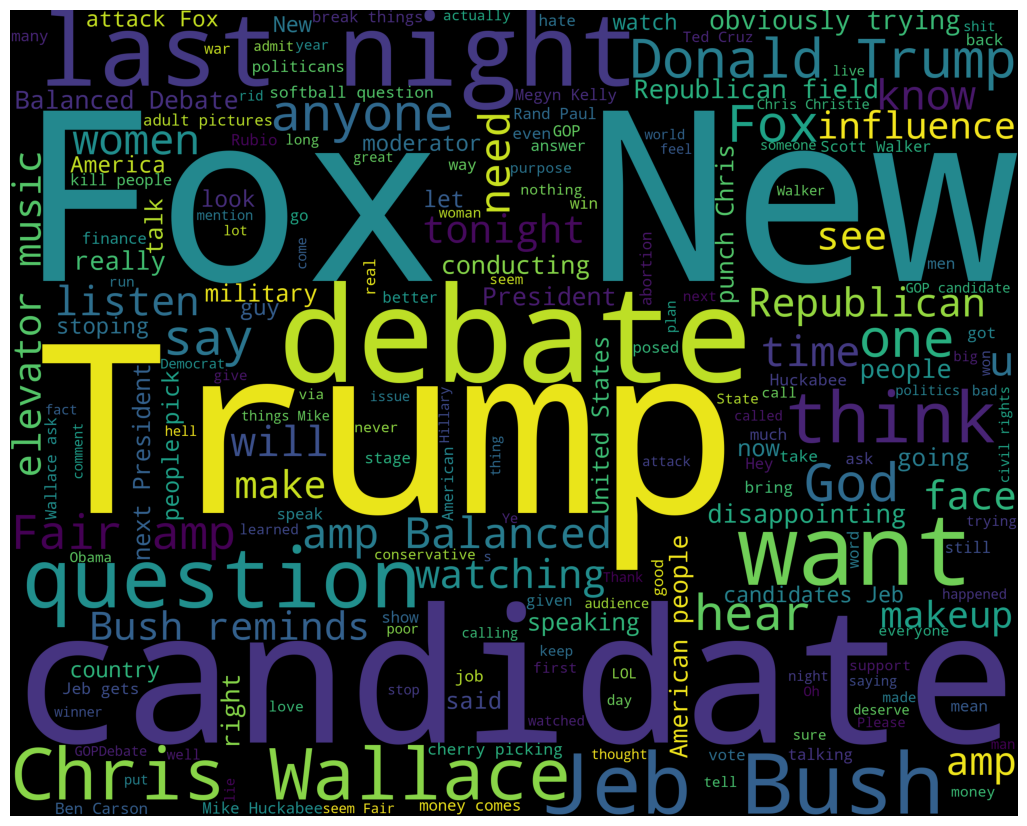

In [5]:
train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['text']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

Genellikle bu kelimeler gereksiz çok miktarda bilgi döndürdükleri için arama sorgularından filtrelenirler.

In [6]:
tweets = []
stopwords_set = set(stopwords.words("english"))

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords, row.sentiment))

test_pos = test[ test['sentiment'] == 'Positive']
test_pos = test_pos['text']
test_neg = test[ test['sentiment'] == 'Negative']
test_neg = test_neg['text']

Bir sonraki adımda nltk lib ile önce sık dağılımları ölçerek ve çıkan anahtarları seçerek sözde özellikleri çıkarıyoruz.

In [7]:
# Kelime özelliklerinin çıkarılması
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

Burada en sık dağıtılan kelimeleri çizdik. En çok kelime tartışma gecelerinde merkezleniyor

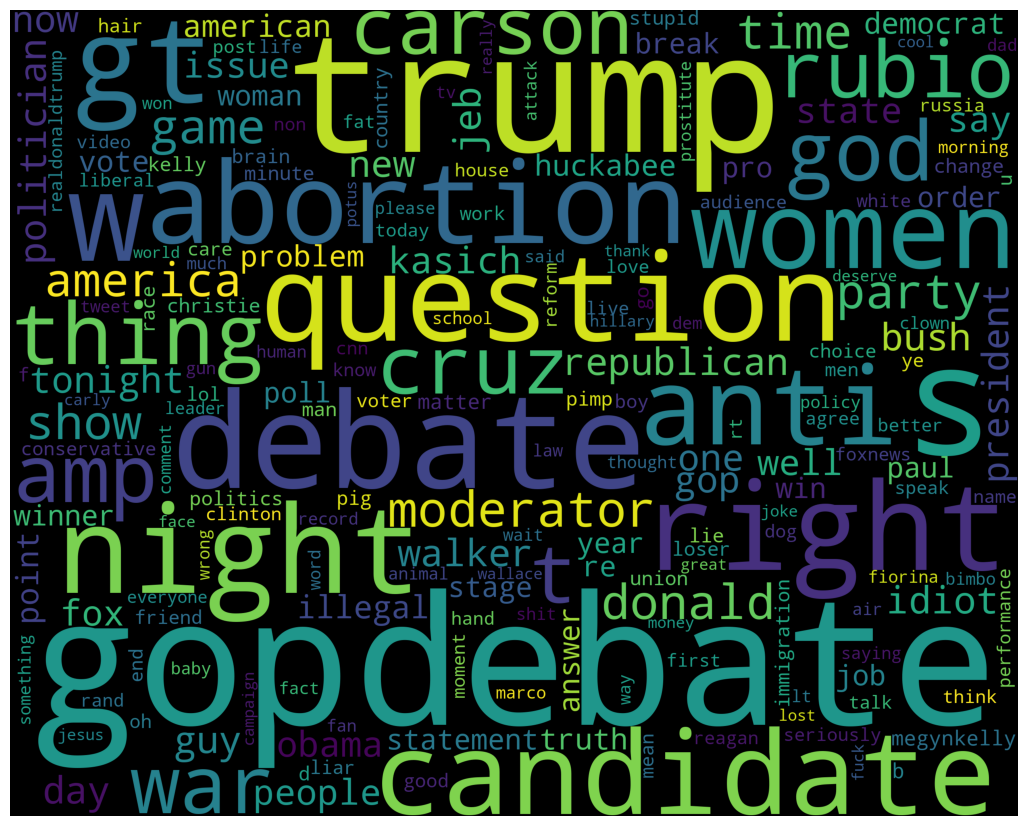

In [8]:
wordcloud_draw(w_features)

Çıkarılan tweet kelime özelliklerini nltk NaiveBayes Sınıflandırıcısı'nı kullanarak sınıflandırıyoruz.

In [9]:
# Naive Bayes sınfını eğitiyoruz
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

Son olarak pek de akıllıca olmayan metriklerle sınıflandırıcı algoritmanın nasıl puan aldığını ölçmeye çalışıyoruz..

In [10]:
neg_cnt = 0
pos_cnt = 0
for obj in test_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Negative'): 
        neg_cnt = neg_cnt + 1
for obj in test_pos: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Positive'): 
        pos_cnt = pos_cnt + 1
        
print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))        
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt)) 

[Negative]: 830/790 
[Positive]: 222/91 
